# **Data Cleaning Notebook**

## Objectives

- Evaluate missing data and outliers
- Analyze zero vs. NaN semantics for key features
- Quantify distributions and skewness to justify imputation methods
- Clean data (drop, impute, handle outliers)
- Generate cleaned Train and Test sets, saved to outputs/datasets/cleaned and export pipeline


## Inputs

- outputs/datasets/collection/HousePrices.csv

## Outputs

- Cleaned full dataset: outputs/datasets/cleaned/HousePricesCleaned.csv
- Cleaned train/test splits: outputs/datasets/cleaned/TrainSetCleaned.csv, outputs/datasets/cleaned/TestSetCleaned.csv
- Data cleaning pipeline: outputs/ml_pipeline/data_cleaning/dataCleaning_pipeline.pkl


---

### Change Working Directory

In [1]:
import os

current_dir = os.getcwd()
os.chdir(os.path.dirname(current_dir))  # set project root
print("Current directory:", os.getcwd())

Current directory: /workspaces/heritage-housing-issues


---

### Load Collected Data

In [2]:
import pandas as pd

df = pd.read_csv("outputs/datasets/collection/HousePrices.csv")
df.head(5)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500
3,961,NaN,NaN,No,216,ALQ,540,NaN,642,Unf,...,60.0,0.0,35,5,7,756,NaN,1915,1970,140000
4,1145,NaN,4.0,Av,655,GLQ,490,0.0,836,RFn,...,84.0,350.0,84,5,8,1145,NaN,2000,2000,250000


## Identify columns with missing values

In [3]:
vars_with_missing = df.columns[df.isna().sum() > 0].tolist()
print("Columns with missing:", vars_with_missing)
print(df[vars_with_missing].info())

Columns with missing: ['2ndFlrSF', 'BedroomAbvGr', 'BsmtExposure', 'BsmtFinType1', 'EnclosedPorch', 'GarageFinish', 'GarageYrBlt', 'LotFrontage', 'MasVnrArea', 'WoodDeckSF']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   2ndFlrSF       1374 non-null   float64
 1   BedroomAbvGr   1361 non-null   float64
 2   BsmtExposure   1422 non-null   object 
 3   BsmtFinType1   1315 non-null   object 
 4   EnclosedPorch  136 non-null    float64
 5   GarageFinish   1225 non-null   object 
 6   GarageYrBlt    1379 non-null   float64
 7   LotFrontage    1201 non-null   float64
 8   MasVnrArea     1452 non-null   float64
 9   WoodDeckSF     155 non-null    float64
dtypes: float64(7), object(3)
memory usage: 114.2+ KB
None


## Evaluate missing data levels

In [4]:
def EvaluateMissingData(df):
    missing_abs = df.isnull().sum()
    missing_pct = (missing_abs / len(df) * 100).round(2)
    return (
        pd.DataFrame(
            {"MissingCount": missing_abs, "MissingPct": missing_pct, "DType": df.dtypes}
        )
        .query("MissingPct > 0")
        .sort_values(by="MissingPct", ascending=False)
    )


print(EvaluateMissingData(df))

               MissingCount  MissingPct    DType
EnclosedPorch          1324       90.68  float64
WoodDeckSF             1305       89.38  float64
LotFrontage             259       17.74  float64
GarageFinish            235       16.10   object
BsmtFinType1            145        9.93   object
BedroomAbvGr             99        6.78  float64
2ndFlrSF                 86        5.89  float64
GarageYrBlt              81        5.55  float64
BsmtExposure             38        2.60   object
MasVnrArea                8        0.55  float64


---

## 0 vs NaN Analysis for EnclosedPorch, WoodDeckSF

In [5]:
for col in ["EnclosedPorch", "WoodDeckSF"]:
    zeros = (df[col] == 0).sum()
    nans = df[col].isna().sum()
    print(f"{col}: zeros={zeros}, NaNs={nans}, total={len(df)}")

EnclosedPorch: zeros=116, NaNs=1324, total=1460
WoodDeckSF: zeros=78, NaNs=1305, total=1460


Interpretation: If 0 entries represent "no porch/deck", we might keep zeros and drop NaNs separately, but since NaN missing >85%, we will drop these features.

---

## Outlier Detection (IQR Method)

In [6]:
import numpy as np

numeric_cols = df.select_dtypes(include=["float64", "int64"]).columns.tolist()
outliers_summary = []
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)].shape[0]
    outliers_summary.append((col, outliers))
outliers_df = pd.DataFrame(
    outliers_summary, columns=["Variable", "OutlierCount"]
).sort_values("OutlierCount", ascending=False)
outliers_df.head(10)

,Variable,OutlierCount
13,OverallCond,125
11,MasVnrArea,96
10,LotFrontage,88
12,OpenPorchSF,77
9,LotArea,69
15,TotalBsmtSF,61
19,SalePrice,61
2,BedroomAbvGr,34
8,GrLivArea,31
4,BsmtUnfSF,29


Next steps: Decide later whether to Winsorize or remove specific extreme outliers in Modeling stage.

---

## Distribution & Skewness Analysis for Imputation

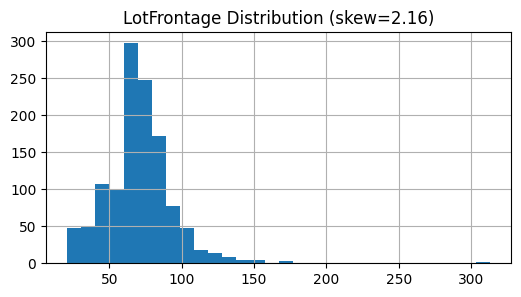

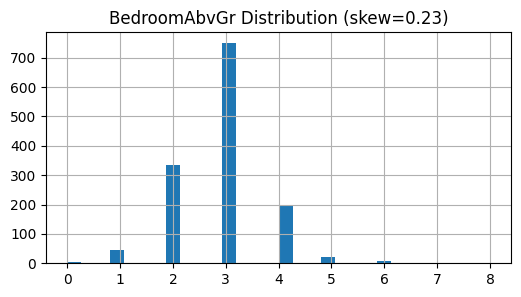

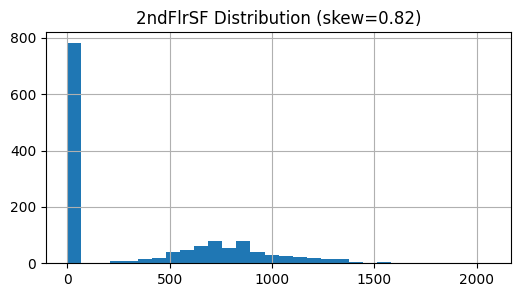

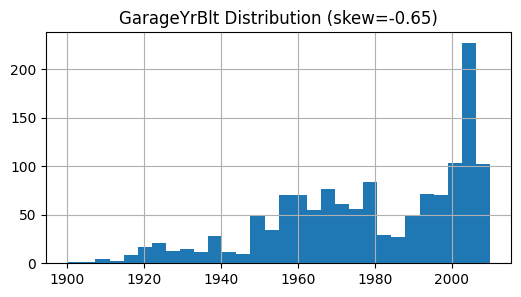

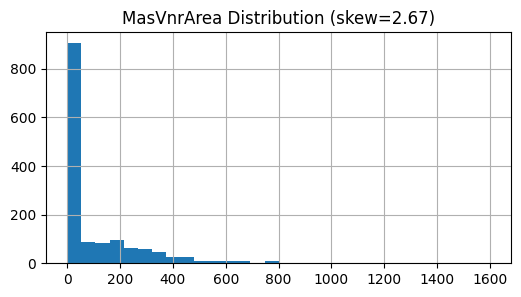

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

vars_mean = ["LotFrontage", "BedroomAbvGr"]
vars_median = ["2ndFlrSF", "GarageYrBlt", "MasVnrArea"]

# Compute skewness
skew_info = pd.Series(df[vars_mean + vars_median].skew()).to_frame("Skewness")
skew_info

# Plot histograms\import matplotlib.pyplot as plt
for col in vars_mean + vars_median:
    plt.figure(figsize=(6, 3))
    df[col].hist(bins=30)
    plt.title(f"{col} Distribution (skew={skew_info.loc[col,'Skewness']:.2f})")
    plt.show()

Justification:
- vars_mean skewness near 0 ⇒ mean imputation appropriate
- vars_median moderate skew >0.5 ⇒ median imputation more robust

---

## Profile Report (Missing Variables Only)

In [9]:
from ydata_profiling import ProfileReport

profile = ProfileReport(df[vars_with_missing], minimal=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

---

## Data Cleaning Functions

In [12]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def EvaluateMissingData(df):
    """
    Calculate absolute and percentage of missing values per column.
    Returns a DataFrame sorted by MissingPct descending.
    """
    missing_abs = df.isnull().sum()
    missing_pct = (missing_abs / len(df) * 100).round(2)
    return (
        pd.DataFrame({
            "MissingCount": missing_abs,
            "MissingPct": missing_pct,
            "DType": df.dtypes
        })
        .query("MissingPct > 0")
        .sort_values(by="MissingPct", ascending=False)
    )

def DataCleaningEffect(df_orig, df_clean, vars_applied):
    """
    Display before/after distributions for specified variables.
    Categorical: countplots; Numerical: density histograms.
    """
    print("\n" + "=" * 60)
    print("Visual Comparison of Distributions\n")
    for var in vars_applied:
        plt.figure(figsize=(6, 3))
        if df_orig[var].dtype == "object":
            sns.countplot(x=var, data=df_orig, label="Original")
            sns.countplot(x=var, data=df_clean, label="Cleaned", alpha=0.7)
        else:
            sns.histplot(df_orig[var], element="step", stat="density", label="Original")
            sns.histplot(df_clean[var], element="step", stat="density", label="Cleaned")
        plt.title(f"{var} Before vs After Cleaning")
        plt.legend()
        plt.show()


---

## Data Cleaning Summary & Decisions
- Drop features: EnclosedPorch, WoodDeckSF (NaN >85%)
- Impute mean: LotFrontage, BedroomAbvGr
- Impute median: 2ndFlrSF, GarageYrBlt, MasVnrArea
- Impute categorical: GarageFinish, BsmtFinType1, also BsmtExposure (fill with 'None')

---

### Split Dataset into Train and Test 

In [13]:
from sklearn.model_selection import train_test_split
TrainSet, TestSet = train_test_split(df, test_size=0.2, random_state=0)
print(f"TrainSet: {TrainSet.shape} \nTestSet shape: {TestSet.shape}")

TrainSet: (1168, 24) 
TestSet shape: (292, 24)


### Verify TrainSet missing before cleaning

In [14]:
print(EvaluateMissingData(TrainSet))

               MissingCount  MissingPct    DType
EnclosedPorch          1056       90.41  float64
WoodDeckSF             1034       88.53  float64
LotFrontage             212       18.15  float64
GarageFinish            184       15.75   object
BsmtFinType1            114        9.76   object
BedroomAbvGr             80        6.85  float64
2ndFlrSF                 60        5.14  float64
GarageYrBlt              58        4.97  float64
BsmtExposure             28        2.40   object
MasVnrArea                6        0.51  float64


---

## Apply Data Cleaning Pipeline (separate fit/transform)

Train missing:
 Empty DataFrame
Columns: [MissingCount, MissingPct, DType]
Index: []
Test missing:
 Empty DataFrame
Columns: [MissingCount, MissingPct, DType]
Index: []
Full missing:
 Empty DataFrame
Columns: [MissingCount, MissingPct, DType]
Index: []

Visual Comparison of Distributions



/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/imputation/categorical.py:232: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[variable]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/imputation/categorical.py:232: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[variable]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/imputation/categorical.py:232: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[variable]):


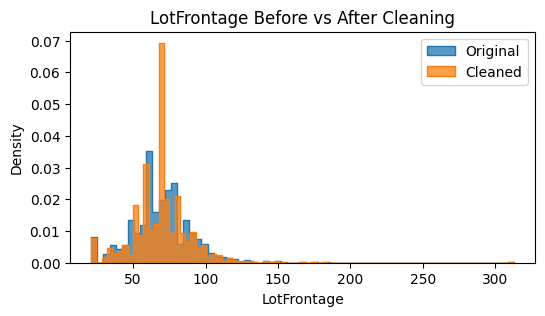

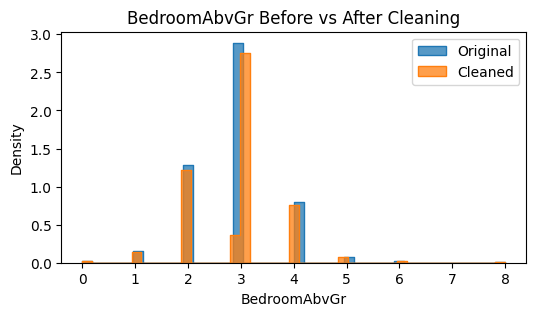

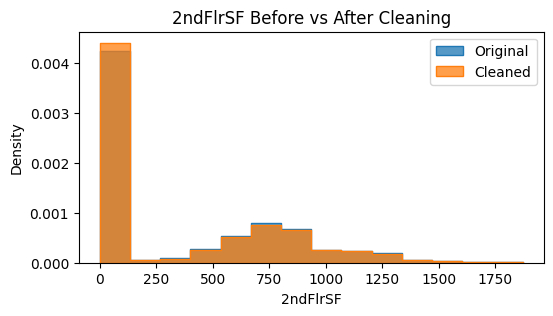

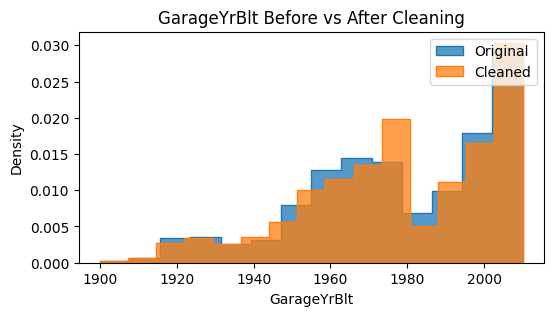

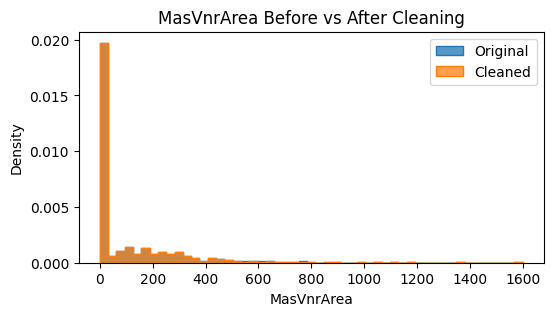

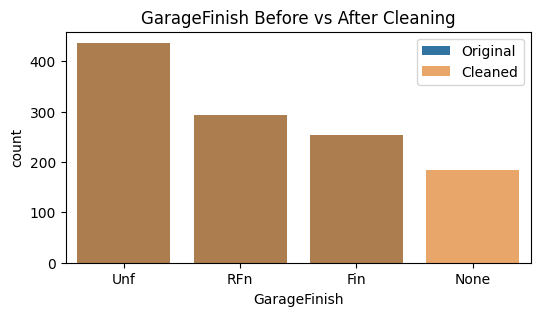

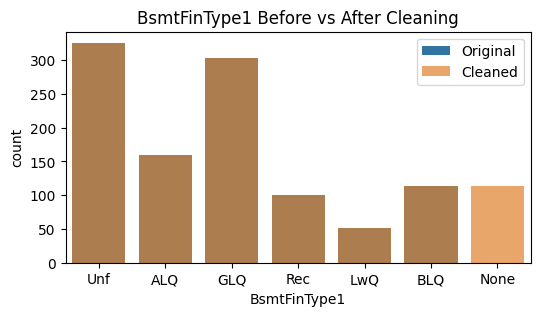

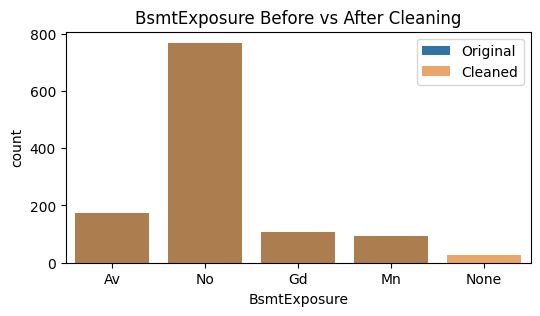

In [15]:
from feature_engine.selection import DropFeatures
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer
from sklearn.pipeline import Pipeline

# Define steps
drop_vars = ["EnclosedPorch", "WoodDeckSF"]
mean_vars = vars_mean
median_vars = vars_median
cat_vars = ["GarageFinish", "BsmtFinType1", "BsmtExposure"]

pipeline = Pipeline(
    [
        ("drop", DropFeatures(features_to_drop=drop_vars)),
        ("mean", MeanMedianImputer(imputation_method="mean", variables=mean_vars)),
        (
            "median",
            MeanMedianImputer(imputation_method="median", variables=median_vars),
        ),
        (
            "cat",
            CategoricalImputer(
                imputation_method="missing", fill_value="None", variables=cat_vars
            ),
        ),
    ]
)

# Fit on Train, transform both
pipeline.fit(TrainSet)
TrainCleaned = pipeline.transform(TrainSet)
TestCleaned = pipeline.transform(TestSet)
FullCleaned = pipeline.transform(df)

# Check missing after cleaning
print("Train missing:\n", EvaluateMissingData(TrainCleaned))
print("Test missing:\n", EvaluateMissingData(TestCleaned))
print("Full missing:\n", EvaluateMissingData(FullCleaned))

# Visualize effect for each group
DataCleaningEffect(TrainSet, TrainCleaned, mean_vars + median_vars + cat_vars)

---

## Save Cleaned Data and Pipeline

In [16]:
# Create output dirs
os.makedirs("outputs/datasets/cleaned", exist_ok=True)
# Save CSVs
pd.DataFrame(FullCleaned, columns=TrainCleaned.columns).to_csv(
    "outputs/datasets/cleaned/HousePricesCleaned.csv", index=False
)
pd.DataFrame(TrainCleaned, columns=TrainCleaned.columns).to_csv(
    "outputs/datasets/cleaned/TrainSetCleaned.csv", index=False
)
pd.DataFrame(TestCleaned, columns=TestCleaned.columns).to_csv(
    "outputs/datasets/cleaned/TestSetCleaned.csv", index=False
)
# Save pipeline
import joblib

os.makedirs("outputs/ml_pipeline/data_cleaning", exist_ok=True)
joblib.dump(pipeline, "outputs/ml_pipeline/data_cleaning/dataCleaning_pipeline.pkl")

['outputs/ml_pipeline/data_cleaning/dataCleaning_pipeline.pkl']

---

## Summary and Next Steps

**Summary**
- Missing values: All handled
- Outliers: Detected; decide handling strategy in Modeling Notebook.
- Pipeline: Fit on train, transform test/full; avoids data leakage.
- Justifications: Skewness, zero-vs-NaN, distribution plots, IQR analysis.

**Next Steps**:
- Move to Data Study (EDA) Notebook to analyze feature–target relationships and generate visual insights for the dashboard.
